# Demo for launching an experiment set  

*Objectif*: **Comparing some models variability**

An experiment set is a collection of experiments that are part of the same evaluation scenario. 
In this notebook, we're comparing how the (maximum) number of chunks influences the model's performance.

To conduct these experiments, one approach consists by creating an empty experiment set (via POST /experiment_set) and then add a list of experiments to it (via POST /experiment with the reference to the experimentset_id). Each experiment should have all parameters the same, except for the (maximum) number of chunks.

Alternatively, the /experiment_set endpoint offers a convenient feature called cv (short for cross-validation). This feature includes two key parameters:

- **common_params**: These are the parameters that will be shared across all experiments in the set.
- **grid_params**: This allows you to specify a list of varying values for any parameter.


Both **commons_params** and **grid_params** accept all the parameter defined by the ExperimentSetCreate schema.  
The experiments will be generated by combining the **common_params** with each unique set of values from the cartesian product of the lists provided in **grid_params**.

In [52]:
import os
import sys
import time

import dotenv
from IPython.display import HTML
import numpy as np
import pandas as pd
import requests

dotenv.load_dotenv("../.env")
sys.path.append("..")
from api.utils import log_and_raise_for_status

API_URL = "http://localhost:8000"
ALBERT_API_URL = "https://albert.api.etalab.gouv.fr/v1"
ALBERT_API_KEY = os.getenv("ALBERT_API_KEY")
MFS_API_URL = "https://franceservices.staging.etalab.gouv.fr/api/v1"
MFS_API_KEY = os.getenv("MFS_API_KEY")

## Designing and running an experiment set

In [51]:
# Designing my experiments
# --
expset_name = "fs_variability_v2"
expset_readme = "omparing some models variability."
metrics = ["answer_relevancy", "judge_exactness", "judge_notator", "output_length", "generation_time"]
common_params = {
    "dataset" : "MFS_questions_v01",
    "sampling_params" : {"temperature": 0.2},
    "metrics" : metrics
}
grid_params = {
    "model": [
        {"name": "AgentPublic/llama3-instruct-8b",         "base_url": ALBERT_API_URL, "api_key": ALBERT_API_KEY},
        {"name": "meta-llama/Meta-Llama-3.1-8B-Instruct",  "base_url": ALBERT_API_URL, "api_key": ALBERT_API_KEY},
        {"name": "meta-llama/Meta-Llama-3.1-70B-Instruct", "base_url": ALBERT_API_URL, "api_key": ALBERT_API_KEY},
    ],
}

# Lauching the experiment set
expset = {
    "name" : expset_name, 
    "readme": expset_readme,
    "cv": {"common_params": common_params, "grid_params": grid_params, "repeat":10}
}
response = requests.post(f'{API_URL}/v1/experiment_set', json=expset)
resp = response.json()
if "id" in resp:
    expset_id = resp["id"]
    print(f'Created expset: {resp["name"]} ({resp["id"]})')
else:
    print(resp)

Created expset: fs_variability_v2 (9)


## Reading and showing results

-> Show the mean and std score, for each metrics, across the experiment repetition. The std show the variability of the model.

In [101]:
# Read results
# --
df_all = None # multi-dimensional DataFrame
arr_all = {} # keep references of source array per metric metrics 

# Fetch results and compute macro metrics (mean, std etc).
# --
response = requests.get(f'{API_URL}/v1/experiment_set/{expset_id}')
expset = response.json()
rows = []
for i, exp in enumerate(expset["experiments"]):
    # Get an experiment result
    exp_id = exp["id"]
    response = requests.get(f'{API_URL}/v1/experiment/{exp_id}?with_results=true')
    experiment = response.json()
    # experiment["name"] # Name of the experiment
    if experiment["experiment_status"] != "finished":
        print(f"Warning: experiment {exp_id} is not finished yet...")
    results = experiment["results"]
    model = experiment["model"]["name"]
    
    # Add an observation row from the observation_table (mean, std etc)
    row = {"model": model}
    rows.append(row)
    metric_arrs = {}
    arr_all[model] = metric_arrs
    for metric_results in results: 
        metric = metric_results["metric_name"]
        arr = np.array([x["score"] for x in metric_results["observation_table"] if pd.notna(x["score"])])
        row[(metric, 'mean')] = np.mean(arr)
        row[(metric, 'std')] = np.std(arr)
        row[(metric, 'median')] = np.median(arr)
        row[(metric, 'mean_std')] = f"{arr.mean():.2f} ± {arr.std():.2f}"  # Formatting as 'mean±std'
        row[(metric, 'support')] = len(arr)
        metric_arrs[metric] = arr
    
df_all = pd.DataFrame(rows)
df_all.set_index('model', inplace=True)
df_all.columns = pd.MultiIndex.from_tuples(df_all.columns)
final_df = df_all.xs('mean', axis=1, level=1)
#final_df["support"] = supports # for debugging

# Group and average the result of the experiments by models
# --
def format_metrics(row):
   metrics = {}
   for metric in final_df.columns.levels[0]:
       mean_value = row[(metric, 'mean')]
       std_value = row[(metric, 'std')]
       metrics[metric] = f"{mean_value:.2f} ± {std_value:.2f}"
   return pd.Series(metrics)
final_df = final_df.groupby(level=0).agg(['mean', 'std'])  # groupby "model"
final_df.index.name = None
final_df = final_df.apply(format_metrics, axis=1) # final formating
final_df = final_df.reindex([m["name"] for m in grid_params["model"]]) # reorder rows
final_df = final_df[metrics] # reorder columns
final_df

,answer_relevancy,judge_exactness,judge_notator,output_length,generation_time
AgentPublic/llama3-instruct-8b,0.92 ± 0.02,0.03 ± 0.02,3.37 ± 0.15,309.97 ± 7.37,6.69 ± 0.13
meta-llama/Meta-Llama-3.1-8B-Instruct,0.92 ± 0.03,0.02 ± 0.02,3.60 ± 0.12,296.09 ± 10.61,3.80 ± 0.14
meta-llama/Meta-Llama-3.1-70B-Instruct,0.96 ± 0.02,0.08 ± 0.03,4.87 ± 0.22,240.28 ± 13.35,9.10 ± 0.60


# Visualize the score dispersion for each metrics.

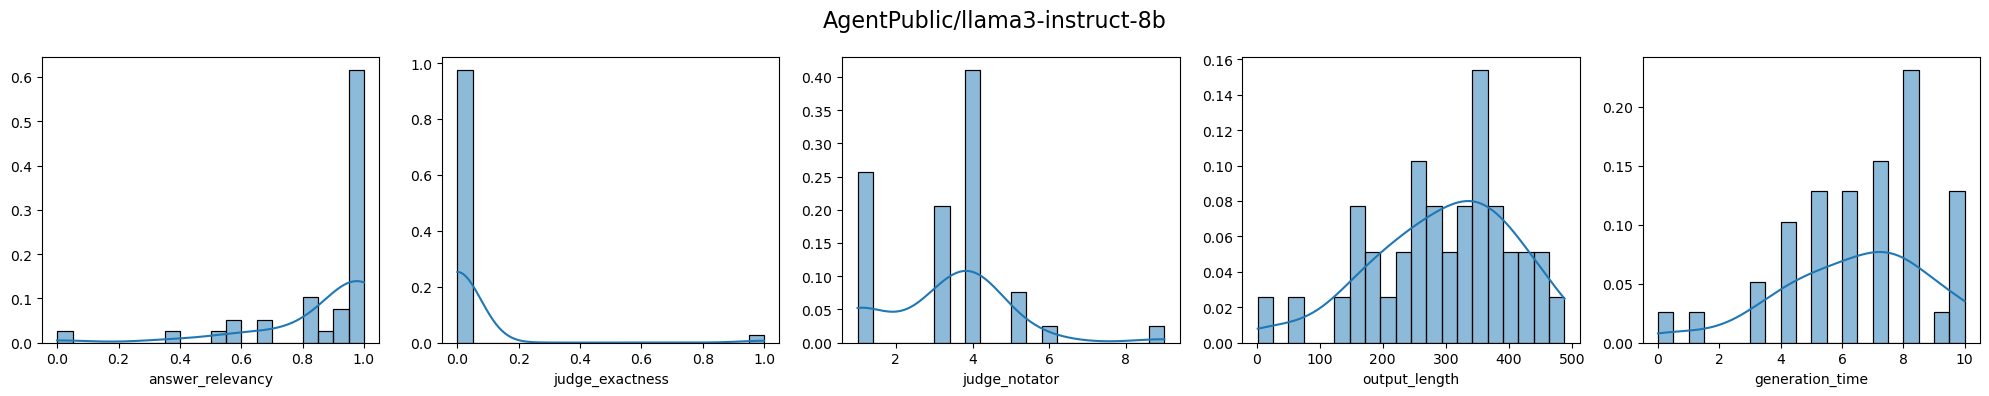

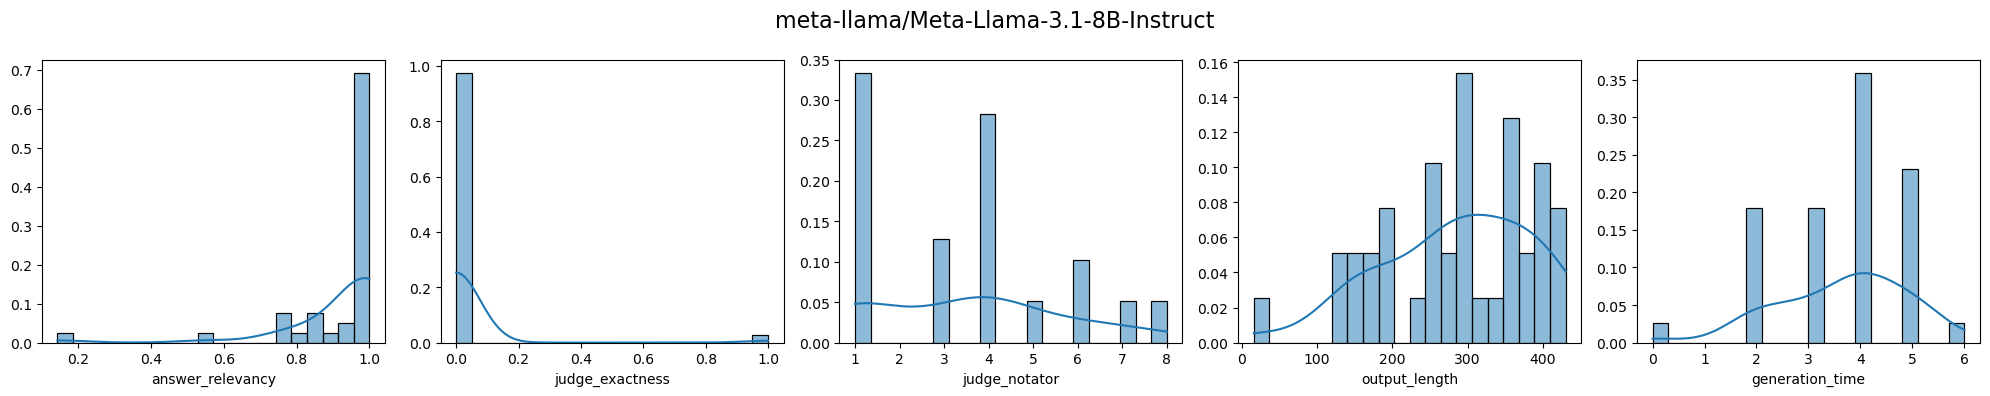

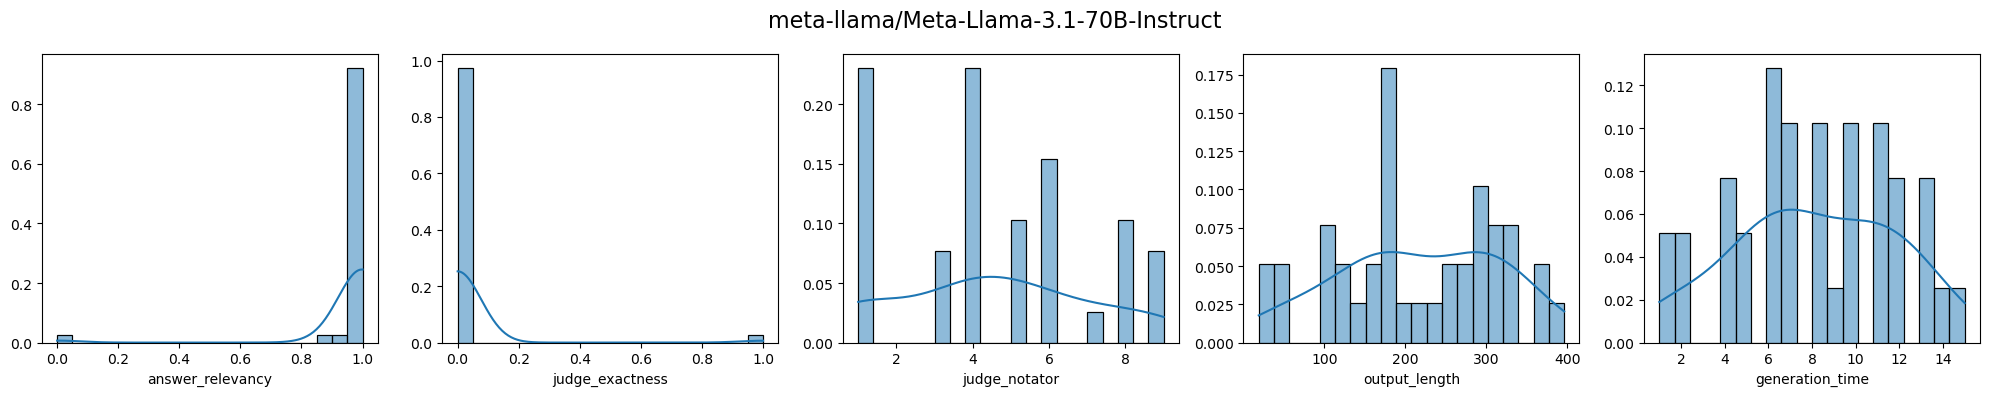

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns

for model, metrics_arr in arr_all.items():
    experiment_title = model
    metrics_arr = {k:metrics_arr[k] for k in metrics} # reorder metrics
    arr_metrics = np.array(list(metrics_arr.values()))
    df = pd.DataFrame(arr_metrics.T, columns=metrics_arr.keys())
    
    num_cols = 5
    num_plots = len(df.columns)
    num_rows = (num_plots + num_cols - 1) // num_cols  
    plt.figure(figsize=(num_cols * 4, num_rows * 4))
    for i, column in enumerate(df.columns, 1):
        plt.subplot(num_rows, num_cols, i)
        sns.histplot(df[column], bins=20, stat="probability", element="bars", kde=True)
        plt.ylabel("") 
    
    plt.suptitle(experiment_title, fontsize=16)
    plt.tight_layout()
    plt.show()